In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import argparse

JESTER_dir = "./JESTER/"

jokeset_file = "Dataset4JokeSet.xlsx"
ratings_file = "[final] April 2015 to Nov 30 2019 - Transformed Jester Data - .xlsx"

# Read excel file

In [2]:
jokeset_dir = os.path.join(JESTER_dir, jokeset_file)
ratings_dir = os.path.join(JESTER_dir, ratings_file)

## 1. Jokes in the dataset

In [3]:
jokeset_df = pd.read_excel(jokeset_dir, sheet_name = "Sheet1",
                           header=None, names=["joke"], dtype=str)
jokeset_df["joke id"] = jokeset_df.index + 1
jokeset_df["word count"] = jokeset_df["joke"].str.split().str.len()
jokeset_df = jokeset_df.reindex(columns = ["joke id", "joke", "word count"])

print("- There are total {} number of jokes.".format(len(jokeset_df['joke id'])))

jokeset_df.head()

- There are total 158 number of jokes.


,joke id,joke,word count
0,1,"A man visits the doctor. The doctor says ""I ha...",28
1,2,This couple had an excellent relationship goin...,71
2,3,Q. What's 200 feet long and has 4 teeth? A. ...,18
3,4,Q. What's the difference between a man and a t...,21
4,5,Q.\tWhat's O. J. Simpson's Internet address? ...,14


## 2. Ratings in the dataset

In [4]:
joke_ids = list(jokeset_df["joke id"])
ratings_df = pd.read_excel(ratings_dir, sheet_name ="Sheet1",
                           header=None, names=["rated counts"]+joke_ids, dtype=float)
ratings_df["user id"] = ratings_df.index + 1
ratings_df = ratings_df.reindex(columns = ["user id", "rated counts"]+joke_ids)
ratings_df[ratings_df[joke_ids]==99.0] = None

print("- There are total {} number of ratings given by {} users".format(
                                            sum(list(ratings_df[joke_ids].count())),
                                            len(ratings_df["user id"])))

ratings_df.head()

- There are total 106489 number of ratings given by 7699 users


,user id,rated counts,1,2,3,4,5,6,7,8,...,149,150,151,152,153,154,155,156,157,158
0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.61,-4.51,0.0,0.0,NaN,0.0,5.93,4.19
4,5,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00


# Analysis on the dataset

### Histogram: Word counts in each sentence

/home/njh/virtualenv_list/eval/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


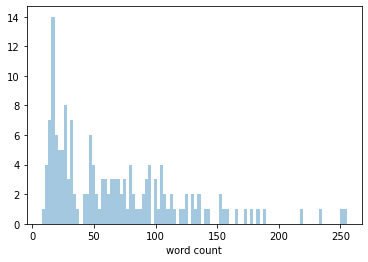

In [5]:
bins = len(set(list(jokeset_df["word count"])))
sns.distplot(jokeset_df["word count"], bins = bins, kde=False)

## Histogram: Number of rated jokes by each user

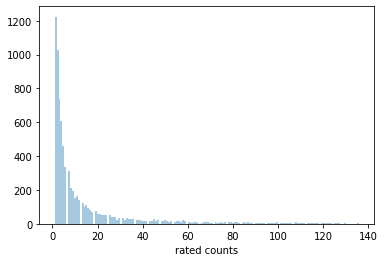

In [6]:
sns.distplot(ratings_df["rated counts"], bins = 158, kde=False)

The result seems like most of the users had rated under 20 jokes.

According to the [JESTER dataset official site](http://eigentaste.berkeley.edu/dataset/), some samples(jokes) from the dataset was not rated by any users.

# Scatter Plot: ratings count by word count in each joke

- There are total 106489 number of ratings given by 7699 users


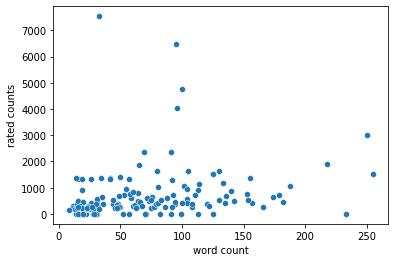

In [7]:
df = pd.DataFrame({"joke id": joke_ids, "rated counts": ratings_df[joke_ids].count()})
df = pd.merge(jokeset_df, df, on="joke id")

print("- There are total {} number of ratings given by {} users".format(
                                            df["rated counts"].sum(),
                                            len(ratings_df["user id"])))

sns.scatterplot(data=df, x="word count", y="rated counts")

I first thought that each joke's rated count will decrease as the one's length increase.

But the scatter plot above shows that the correlation between rated count and joke length are negligible.

However, let's eliminate samples(jokes) with long sentence length based on word count for users' readability during the user study.

# Eliminate long samples(jokes)

In [8]:
word_count_threshold = 100

eliminated_jokes_ids = list(df[df["word count"]>=word_count_threshold]["joke id"])
remaining_jokes_ids = list(df[df["word count"]<word_count_threshold]["joke id"])

# delete eliminated jokes from the jokeset dataframe
jokeset_df = jokeset_df[jokeset_df["word count"]<word_count_threshold]

# delete eliminated jokes from the ratings dataframe
ratings_df.drop(eliminated_jokes_ids, axis = 1, inplace=True)

# update the rated counts in ratings dataframe
ratings_df["rated counts"] = ratings_df[remaining_jokes_ids].count(axis=1)

# delete eliminated jokes from merged dataframe
processed_df = df[df["word count"]<word_count_threshold]

print("- There are {} number of ratings on jokes with under {} words lenght.".format(
                                                                                processed_df["rated counts"].sum(),
                                                                                word_count_threshold))
print("- {} jokes are eliminated from the dataset.".format(len(eliminated_jokes_ids)))
print("- There are {} users have no ratings.".format(len(ratings_df[ratings_df["rated counts"] == 0])))
print("- {:.2f}% of the ratings from the dataset remaining.".format(processed_df["rated counts"].sum()/df["rated counts"].sum()*100))

- There are 72673 number of ratings on jokes with under 100 words lenght.
- 37 jokes are eliminated from the dataset.
- There are 55 users have no ratings.
- 68.24% of the ratings from the dataset remaining.


/home/njh/virtualenv_list/eval/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


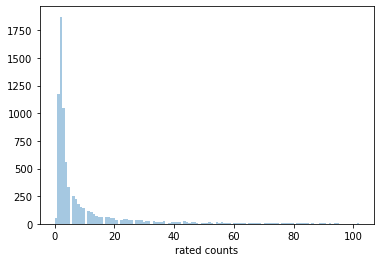

In [9]:
sns.distplot(ratings_df["rated counts"], bins = len(remaining_jokes_ids),kde=False)

The distribution hasn't changed from the original dataset.

However, the number of users who haven't rated any jokes is increased.

# Eliminate users with 0 or 1 rating
Since I am going to split the dataset into train and test datasets from ratings grouped by users, each user should at least gave 2 ratings so each one can belong to train and test datasets.

In [10]:
print(" - There were {} users in the dataset before,".format(len(ratings_df)))
ratings_df = ratings_df[ratings_df['rated counts'] >= 2]
print(" - After eliminating users with 0 or 1 rating, there are {} users remain in the dataset".format(len(ratings_df)))

 - There were 7699 users in the dataset before,
 - After eliminating users with 0 or 1 rating, there are 6467 users remain in the dataset


# Encode remaining samples(jokes) with sentence transformer

In [11]:
from sentence_transformers import SentenceTransformer

In [12]:
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens')
embeddings = model.encode(list(jokeset_df["joke"]))
jokeset_df["embedding"] = list(embeddings)

# Save preprocessed dataset as csv

In [13]:
jokeset_df.head()

,joke id,joke,word count,embedding
0,1,"A man visits the doctor. The doctor says ""I ha...",28,"[0.2698162, -0.62762123, 0.29955927, -0.414048..."
1,2,This couple had an excellent relationship goin...,71,"[0.5122608, -0.8958999, -0.54218143, 0.0588614..."
2,3,Q. What's 200 feet long and has 4 teeth? A. ...,18,"[0.089293666, -0.8477798, 0.6520843, 0.6721071..."
3,4,Q. What's the difference between a man and a t...,21,"[0.2803367, -0.810892, 1.2814697, 0.82645166, ..."
4,5,Q.\tWhat's O. J. Simpson's Internet address? ...,14,"[0.20243476, -1.0007236, -0.02575929, 0.456246..."


In [14]:
ratings_df.head()

,user id,rated counts,1,2,3,4,5,7,8,9,...,146,149,151,152,153,154,155,156,157,158
2,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.61,-4.51,0.00,0.00,NaN,0.00,5.93,4.19
4,5,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00
5,6,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00,3.41,NaN,-2.32,NaN,0.00,2.93
6,7,84,NaN,NaN,NaN,NaN,NaN,-4.45,7.54,NaN,...,NaN,-1.97,0.00,0.00,7.38,3.19,-9.33,-7.26,-9.13,-8.19


In [15]:
jokeset_csv = "jokeset_df.pkl"
ratings_csv = "ratings_df.pkl"

jokeset_df.to_pickle(os.path.join(JESTER_dir, jokeset_csv))
ratings_df.to_pickle(os.path.join(JESTER_dir, ratings_csv))

# Build training/testing dataset

## 1. Build `ratings.dat` dataset

In [16]:
from tqdm import tqdm

n_users = len(ratings_df['user id'])
n_jokes = len(jokeset_df['joke id'])

userIds = []
itemIds = []
itemEmbeddings = []
ratings = []

for uid in tqdm(ratings_df['user id']):
    for jid in jokeset_df['joke id']:
        rating = ratings_df[ratings_df['user id'] == uid][jid]
        if rating.isnull().item():
            continue
        userIds.append(uid)
        itemIds.append(jid)
        itemEmbeddings.append(jokeset_df[jokeset_df['joke id'] == jid]['embedding'].item())
        ratings.append(rating.item())

ratings = pd.DataFrame({'userId':userIds,
                        'itemId':itemIds, 
                        'itemEmbedding':itemEmbeddings, 
                        'rating':ratings})

100%|██████████| 6467/6467 [06:10<00:00, 17.46it/s]


In [17]:
ratings.head()

,userId,itemId,itemEmbedding,rating
0,3,19,"[-0.09787777, -0.493873, 0.08016377, 0.960561,...",-5.98
1,3,35,"[0.6903751, -0.4762124, 0.069981754, 0.3361252...",-4.47
2,3,72,"[0.2997466, 0.378846, -0.15971746, -0.5418447,...",1.59
3,4,19,"[-0.09787777, -0.493873, 0.08016377, 0.960561,...",-5.41
4,4,21,"[0.11848501, 0.27632087, 0.7251185, 0.23305702...",-4.59


In [18]:
ratings_dat = "ratings.dat"
ratings.to_pickle(os.path.join(JESTER_dir, ratings_dat))

## 2. Save details of the dataset

In [19]:
import json

In [20]:
dataset_params = {}

dataset_params['total samples'] = len(ratings)

In [21]:
params_json = 'dataset_params.json'

with open(os.path.join(JESTER_dir, params_json), 'w') as json_file:
    json.dump(dataset_params, json_file)